### 데이터 탐색
Santander Value Prediction Challenge의 목적은   
Predict the value of transactions for potential customers 하는 것이다.  
즉, 고객들과의 거래 내역을 바탕으로 잠재된 고객의 포텐셜한 가치를 예측하는것이다

대회설명만으로 COL에 존재하는 고객들이 기존의 고객인지 아니면 다른 카테고리의 고객인지는 알수 없으나 이들과의 거래에 따라  
ROW에 존재하는 고객들의 가치가 정해진다

자 그럼 데이터를 구경해보자

In [196]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR

%matplotlib inline
plt.rc('font', family='AppleGothic')
plt.rcParams["figure.figsize"] = (20,4)

In [28]:
train_df = pd.read_csv('train.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [29]:
test_df = pd.read_csv('test.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


In [30]:
train_df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [32]:
test_df.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##  첫 탐색
1. 약간 특이한것은 테스트 데이터에 비해 트레인 데이터가 10분의 1로 적다는 것이다. 어떤 의도에서 데이터셋이 이렇게 구성됬는지는 지금 상태에서는 감이 오지 않는다
2. 컬럼이 4991명의 고객과의 트랜잭션 수치이다. 한사람이 이 모두와 거래를 했다는것은 상식적으로 아닐것이라 판단되고 실제로 sparse matrix의 형태를 띄고 있을거라 추측하였다.
3. target의 스케일이 큰것으로 보인다. 실제로 스케일이 클경우 log기반으로 스케일링으로 분산을 줄이는 것이 도움이 될거라 판단이 된다
4. 결론적으로 리그레션 형태의 문제를 푸는것으로 보인다.

### 2번에 대해 확인해보자
1. 먼저 각 컬럼에 대해서 트랜잭션유무를 확인하자 => row에 대해 확인해도 상관없음

In [54]:
id_col_list = train_df.columns.drop(['ID','target'])
id_col_list

Index(['48df886f9', '0deb4b6a8', '34b15f335', 'a8cb14b00', '2f0771a37',
       '30347e683', 'd08d1fbe3', '6ee66e115', '20aa07010', 'dc5a8f1d8',
       ...
       '3ecc09859', '9281abeea', '8675bec0b', '3a13ed79a', 'f677d4d13',
       '71b203550', '137efaa80', 'fb36b89d9', '7e293fbaf', '9fc776466'],
      dtype='object', length=4991)

In [64]:
s = train_df[id_col_list[1]].value_counts()
s

0          4455
1196000       1
6000          1
4000000       1
1000000       1
Name: 0deb4b6a8, dtype: int64

In [66]:
zero_list = []
for col in id_col_list:
    number_of_zero = train_df[col].value_counts()[0] 
    zero_list.append(number_of_zero)

In [79]:
col_zero_df = pd.DataFrame({'col':id_col_list,'zero':zero_list, 'p_zero': list(map(lambda x:x/len(train_df),zero_list))}).set_index('col')
col_zero_df.head()

,p_zero,zero
col,,
48df886f9,0.991254,4420
0deb4b6a8,0.999103,4455
34b15f335,0.992599,4426
a8cb14b00,0.999551,4457
2f0771a37,0.998879,4454


In [80]:
col_zero_df.describe()

,p_zero,zero
count,4991.000000,4991.000000
mean,0.968541,4318.725706
std,0.047923,213.687891
min,0.649024,2894.000000
25%,0.961651,4288.000000
50%,0.988114,4406.000000
75%,0.997982,4450.000000
max,1.000000,4459.000000


col 별로 거래액을 살펴보면 대부분이 0인것을 알수 있고 row별로 보더라도 전체 메트릭스의 경향은 바뀌지 않을것임  
즉. sparse matrix 의 형태라는것을 확인  
보통 이런경우 feature의 차원을 줄이는것이 일반적인 테크닉이다  
하지만, 테스트 셋에 값이 존재할경우 전체의 거래액 합과같은 feature를 사용한다고하면 필요할수 있기때문에 바로 삭제하지않는다

### 3번 target의 값의 스케일이 커보인다. 를 확인해보자

In [107]:
plt.rcParams["figure.figsize"] = (10,4)
train_df['target'].describe()

count    4.459000e+03
mean     5.944923e+06
std      8.234312e+06
min      3.000000e+04
25%      6.000000e+05
50%      2.260000e+06
75%      8.000000e+06
max      4.000000e+07
Name: target, dtype: float64

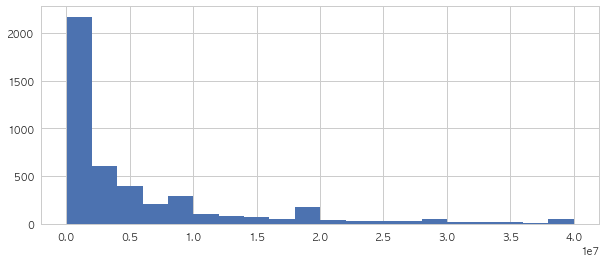

In [108]:
_ = plt.hist(train_df['target'],bins=20)

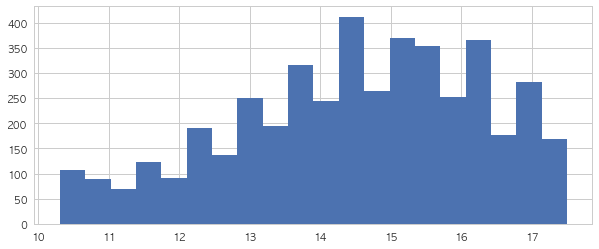

In [109]:
_ = plt.hist(train_df['target'].apply(lambda x:np.log(x)),bins=20)

target값의 분포가 왼쪽으로 skewed 되있다. 이에 로그를 취해 정규분포에 가까운 분포로 변형하였다. 변형시의 이점은 일부 metric의 값이 데이터 분포의 형태에 따라 잘못해석될수 있다.

### 4. regression 문제로 접근해보자
우선 regression 문제를 풀기위해선 회귀모형을 만들고 feature들과 target간의 통계치들을 확인하면서 feature를 제거하는 작업을하게 된다.  
먼저, feature들과 target간의 상관분석을 해보자

In [120]:
%%time
coe_list = []
for col in id_col_list:
    coe = train_df[['target',col]].corr().iloc[0,1] 
    coe_list.append(coe)

CPU times: user 4.78 s, sys: 20 ms, total: 4.8 s
Wall time: 4.81 s


In [139]:
train_df['log_target'] = train_df['target'].apply(lambda x:np.log(x))
log_coe_list = []
for col in id_col_list:
    coe = train_df[['log_target',col]].corr().iloc[0,1] 
    log_coe_list.append(coe)

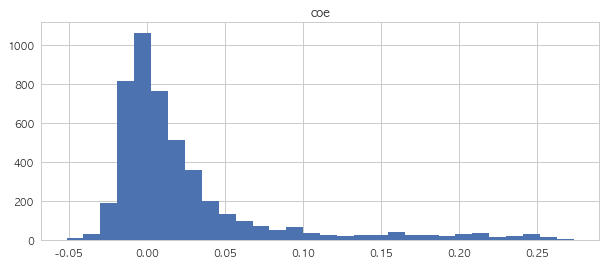

In [140]:
_ = pd.DataFrame({'col':id_col_list,'coe':coe_list}).set_index('col').hist(bins=30)

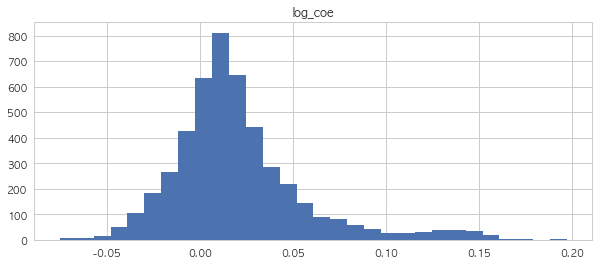

In [141]:
coe_df = pd.DataFrame({'col':id_col_list,'log_coe':log_coe_list}).set_index('col')
_ = coe_df.hist(bins=30)

In [143]:
coe_df.describe()

,log_coe
count,4735.000000
mean,0.020163
std,0.036220
min,-0.075334
25%,-0.000615
50%,0.014176
75%,0.032518
max,0.197227


위와 같이 log 포메이션이 없는 경우에는 아웃라이어에 의해 상관계수가 크게 영향받을수 있음 따라서 log target에 대해 상관계수를 계산한다  
min이 -0.07, max가 0.19로 큰 상관성이 있는 feature들은 보이지않는다.  
이제부터 통계적접근으로 설계하기위해 feature 서로간의 종속성을 분리하고자 feature를 넣고 빼면서 통계치를 확인하여 회귀모델을 설계할수 있지만  
머신러닝 모델을 통해 접근하여보자

# model in output design
input: transaction value, float  
output: target_value

eval_metric = rmsle
rmsle는 결국 target에 log를 취하고 rmse를 구하는것과 유사함, 0일경우 로그가 inf값이기에 +1처리가 필요

In [181]:
cv_train, cv_test = train_test_split(train_df.drop(['target','ID'],axis=1),test_size=0.2,random_state=10)

In [182]:
model_rfr = RandomForestRegressor(n_estimators=100, n_jobs=4,random_state=10)
model_rfr.fit(cv_train.drop(['log_target'],axis=1),cv_train['log_target'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=10,
           verbose=0, warm_start=False)

In [183]:
pred = model_rfr.predict(cv_test.drop(['log_target'],axis=1))
print("RMSE: %.2f"% math.sqrt(np.mean((pred - cv_test['log_target'])**2)))

RMSE: 1.43


현재 1.45의 경우 리더보드에서 2000 / 3600 정도 된다  
나의 목표는 10%안에 들어 동메달을 얻는것이기때문에 좀더 해보도록하자

#### feature scaling
일부 알고리즘의 경우에는 feature스케일링이 필요없지만 빈도가 아닌 metric을 쓰는 알고리즘들은 스케일링에 많은 영향을 받는다 ex)nn, svr

In [184]:
minmax_scaler = MinMaxScaler(feature_range=(0,1))
minmax_scaler.fit(train_df.drop(['target','ID','log_target'],axis=1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [201]:
cv_train, cv_test = train_test_split(train_df.drop(['target','ID'],axis=1),test_size=0.2,random_state=10)

In [185]:
model_svr = LinearSVR(random_state=10)
model_svr.fit(minmax_scaler.transform(cv_train.drop(['log_target'],axis=1)),cv_train['log_target'])

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=10, tol=0.0001, verbose=0)

In [186]:
pred = model_svr.predict(minmax_scaler.transform(cv_test.drop(['log_target'],axis=1)))
print("RMSE: %.2f"% math.sqrt(np.mean((pred - cv_test['log_target'])**2)))

RMSE: 1.75


kaggle에는 역시 esemble이 효과가 좋다. 참고로 랜덤포레스트 리그레서는 스케일링한 X라도 결과는 같다

### feature를 추가하여 보자
1. col_sum
2. transaction_num

#### 1. col_sum

In [233]:
sum_col = 0
for col in train_df.drop(['ID','target','log_target'],axis=1).columns:
    sum_col = sum_col + train_df[col]

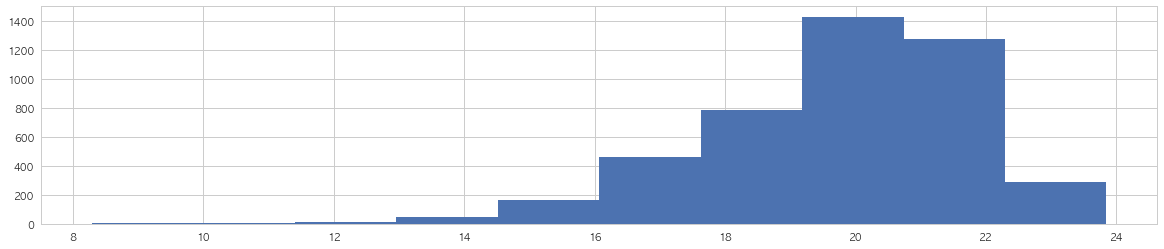

In [236]:
sum_col.apply(lambda x:np.log(x)).hist()

In [239]:
train_df['sum_trans'] = sum_col
train_df['log_sum_trans'] = sum_col.apply(lambda x:np.log(x))

In [242]:
train_df[['target','log_target','sum_trans','log_sum_trans']].corr()

,target,log_target,sum_trans,log_sum_trans
target,1.000000,0.761846,0.271884,0.255374
log_target,0.761846,1.000000,0.206092,0.298094
sum_trans,0.271884,0.206092,1.000000,0.636267
log_sum_trans,0.255374,0.298094,0.636267,1.000000


In [243]:
cv_train, cv_test = train_test_split(train_df.drop(['target','ID'],axis=1),test_size=0.2,random_state=10)

In [245]:
model_rfr = RandomForestRegressor(n_estimators=100, n_jobs=4,random_state=10)
model_rfr.fit(cv_train.drop(['log_target'],axis=1),cv_train['log_target'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=10,
           verbose=0, warm_start=False)

In [246]:
pred = model_rfr.predict(cv_test.drop(['log_target'],axis=1))
print("RMSE: %.2f"% math.sqrt(np.mean((pred - cv_test['log_target'])**2)))

RMSE: 1.42


1.43 -> 1.42 로 약간 감소하였다. 의미가 없진 않은것으로 판단

In [258]:
importances = model_rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

Feature ranking:


In [253]:
indices.shape

(4993,)

0. feature 4991 (0.061557)
1. feature 4992 (0.060368)
2. feature 4358 (0.044874)
3. feature 2500 (0.013403)
4. feature 3660 (0.010144)
5. feature 1797 (0.008115)
6. feature 4084 (0.008027)
7. feature 572 (0.007081)
8. feature 4758 (0.006023)
9. feature 1530 (0.005547)


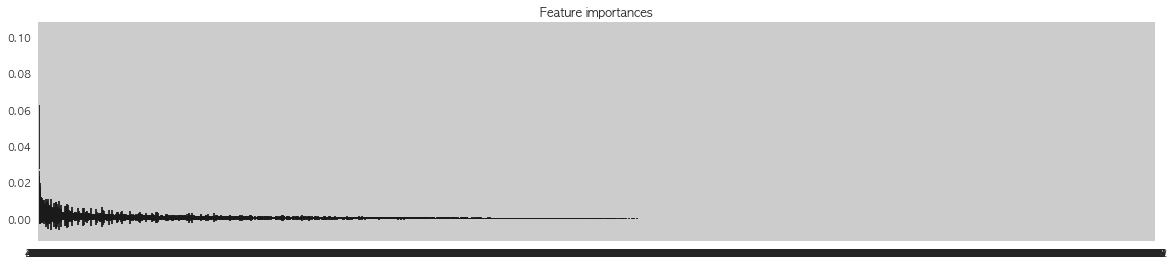

In [260]:
X = cv_train.drop(['log_target'],axis=1)
for f in range(10):
    print("%d. feature %d (%f)" % (f, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [266]:
X.iloc[:,4991].name

'sum_trans'

In [267]:
X.iloc[:,4992].name

'log_sum_trans'

feature

### feature을 selection해보자

In [189]:
col_zero_df[col_zero_df['p_zero']==1].index

Index(['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee',
       '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca',
       ...
       'd196ca1fd', 'a8e562e8e', 'eb6bb7ce1', '5beff147e', '52b347cdc',
       '4600aadcf', '6fa0b9dab', '43d70cc4d', '408021ef8', 'e29d22b59'],
      dtype='object', name='col', length=256)

In [190]:
drop_col_list = col_zero_df[col_zero_df['p_zero']==1].index.tolist()

In [191]:
cv_train, cv_test = train_test_split(train_df.drop(['target','ID']+drop_col_list,axis=1),test_size=0.2,random_state=10)

In [192]:
model_rfr = RandomForestRegressor(n_estimators=100, n_jobs=4,random_state=10)
model_rfr.fit(cv_train.drop(['log_target'],axis=1),cv_train['log_target'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=10,
           verbose=0, warm_start=False)

In [194]:
pred = model_rfr.predict(cv_test.drop(['log_target'],axis=1))
print("RMSE: %.2f"% math.sqrt(np.mean((pred - cv_test['log_target'])**2)))

RMSE: 1.43


zero분포를 가진 col을 빼더라도 효과는 같다.

#### 2. svd를 이용한 feature줄이기